# Predicting Molecular Properties
## Can you measure the magnetic interactions between a pair of atoms?
__CHAMPS (CHemistry And Mathematics in Phase Space)__

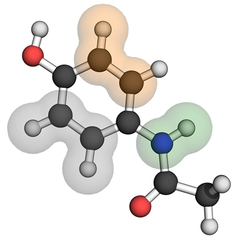


`url:   `[https://www.kaggle.com/c/champs-scalar-coupling/overview](https://www.kaggle.com/c/champs-scalar-coupling/overview)    
`Date:     23/Jun/2019`    
`Updated:  23/Jun/2019`   
`Author:   Enrique Pérez Herrero`

# Predict Potential Energy

This notebook uses the number of dictinct atoms in a molecule to predict, accurately, the molecular potential energy.    The coefficients and the intercept of the linear regression give a closed formula to derive this feature.

In [1]:
import warnings
import numpy as np
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

### Parameters

In [2]:
# Ploting Parameters
FIGSIZE = (10, 6)
sns.set() # Set seaborn style

# Notebook Parameters
SAVE_PICKLE = True
FREE_MEMORY = True
OUTPUT_FILE = "potential_energy_upd"

# kFold Validation Parameters
RANDOM_STATE = 123
N_SPLITS = 3
SHUFFLE = True
VERBOSE = False

## User functions

In [3]:
# Input data user functions

DATA_PATH = "N:\\Users\\Howell\\Kaggle\\Scaler\\champs-scalar-coupling"


def csv_path(dataset="train", data_path=DATA_PATH):
    return "{}/{}.csv".format(data_path, dataset)


def read_data(dataset='train', data_path=DATA_PATH):
    index_col = None
    index_type = ['train', 'test']
    if dataset in index_type:
        index_col = 'id'
    data_path = csv_path(dataset, data_path=data_path)
    return pd.read_csv(data_path, index_col=index_col)

# Read data and arrange Data Frames

In [4]:
train = read_data("train")
test = read_data("test")

## List all atoms in the same molecule

In [5]:
# One row per molecule
molecule_train = pd.DataFrame({"molecule_name" : train["molecule_name"].unique()})
molecule_test = pd.DataFrame({"molecule_name" : test["molecule_name"].unique()})
structures = read_data('structures')
atom_list_df = structures.groupby('molecule_name')['atom'].apply(list)
atom_list_df = atom_list_df.to_frame()

In [9]:
if FREE_MEMORY:
    del train, test

## Merge atoms list to molecule train and test

In [10]:
molecule_train = pd.merge(molecule_train, atom_list_df, how='left', on='molecule_name')
molecule_test = pd.merge(molecule_test, atom_list_df, how='left', on='molecule_name')

## Count distinct atoms in a molecule
The number of distinct atoms in a molecule are the features to use for `Potential Energy` prediction

In [12]:
# Count atoms by type
atoms_list = structures.atom.unique().tolist()
print("Distinct atoms in structures data: \n {}".format(atoms_list))

for atom in atoms_list:
    molecule_train['atom_' + atom] = molecule_train['atom'].apply(lambda x: x.count(atom))
    molecule_test['atom_' + atom] = molecule_test['atom'].apply(lambda x: x.count(atom))

Distinct atoms in structures data: 
 ['C', 'H', 'N', 'O', 'F']


## Merge Potential Energy

In [14]:
potential_energy = read_data("potential_energy")
molecule_train = pd.merge(molecule_train, potential_energy)

In [15]:
if FREE_MEMORY:
    del potential_energy, structures
    del atom_list_df

In [16]:
molecule_train.head()

,molecule_name,atom,atom_C,atom_H,atom_N,atom_O,atom_F,potential_energy
0,dsgdb9nsd_000001,"[C, H, H, H, H]",1,4,0,0,0,-40.52368
1,dsgdb9nsd_000002,"[N, H, H, H]",0,3,1,0,0,-56.56025
2,dsgdb9nsd_000003,"[O, H, H]",0,2,0,1,0,-76.42608
3,dsgdb9nsd_000005,"[C, N, H]",1,1,1,0,0,-93.42849
4,dsgdb9nsd_000007,"[C, C, H, H, H, H, H, H]",2,6,0,0,0,-79.83869


The column `atom` can be useful to calculate the molecular weight

# Fit Linear Model and Validate Results

## Select Features

In [17]:
id_feature = 'molecule_name'
target_feature = (set(molecule_train) - set(molecule_test)).pop()
selected_features = list(molecule_test)
selected_features.remove(id_feature)
selected_features.remove('atom')
print("Selected Features: \t{}".format(selected_features))
print("Target Feature: \t{}".format(target_feature))
print("Id Feature: \t\t{}".format(id_feature))

Selected Features: 	['atom_C', 'atom_H', 'atom_N', 'atom_O', 'atom_F']
Target Feature: 	potential_energy
Id Feature: 		molecule_name


In [18]:
target_feature

'potential_energy'

## Train and test data frames

In [19]:
X = molecule_train[selected_features]
y = molecule_train[target_feature]

## Set k-Fold Validation 

In [20]:
kfold = KFold(n_splits=N_SPLITS,
              random_state=RANDOM_STATE,
              shuffle=SHUFFLE)

In [21]:
fold = 0
r2_scores = []
mse_scores = []
lin_reg = LinearRegression()

for in_index, oof_index in kfold.split(X, y):
    fold += 1
    print("- Training Fold: ({}/{})".format(fold, N_SPLITS))
    X_in, X_oof = X.loc[in_index], X.loc[oof_index]
    y_in, y_oof = y.loc[in_index], y.loc[oof_index]
    
    lin_reg.fit(X_in, y_in)
    y_pred = lin_reg.predict(X_oof)
    r2 = r2_score(y_oof, y_pred)
    r2_scores.append(r2)
    mse_score = mean_squared_error(y_oof, y_pred)
    mse_scores.append(mse_score) 

print('\nkFold Validation Results:')
print(' * Average Variance Score (R2): \t{:.4f}'.format(np.mean(r2_scores)))
print(' * Average Mean squared error (MSE): \t{:.4f}'.format(np.mean(mse_score)))
    

- Training Fold: (1/3)
- Training Fold: (2/3)
- Training Fold: (3/3)

kFold Validation Results:
 * Average Variance Score (R2): 	1.0000
 * Average Mean squared error (MSE): 	0.0016


Explained variance score R2 equal to 1 is perfect prediction

## Plot last fold validation and predicted Potential Energy

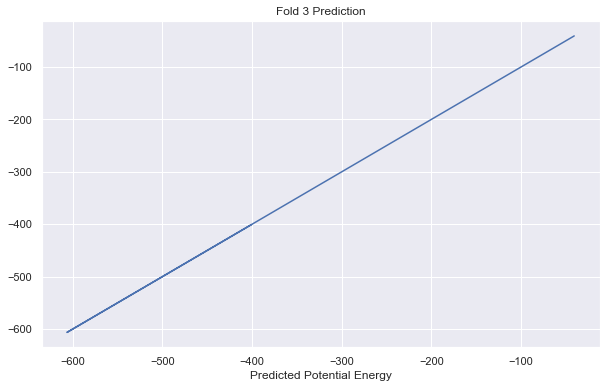

In [22]:
plt.figure(figsize=FIGSIZE)
plt.plot(y_oof, y_pred)
plt.title("Fold {} Prediction".format(fold))
plt.xlabel("Validation Potential Energy")
plt.xlabel("Predicted Potential Energy")
plt.show()

# Predict Potential Energy for test data
Prediction using all available train data 

In [35]:
lin_reg.fit(X, y)
y_test = lin_reg.predict(molecule_test[selected_features])
molecule_test[target_feature] = y_test
if FREE_MEMORY:
    del X, y

## Concatenate `molecule_train` and `molecule_test` in the same data frame

In [36]:
potential_energy_upd = pd.concat([molecule_train[[id_feature, target_feature]],
                                  molecule_test[[id_feature, target_feature]]],
                                 ignore_index=True)

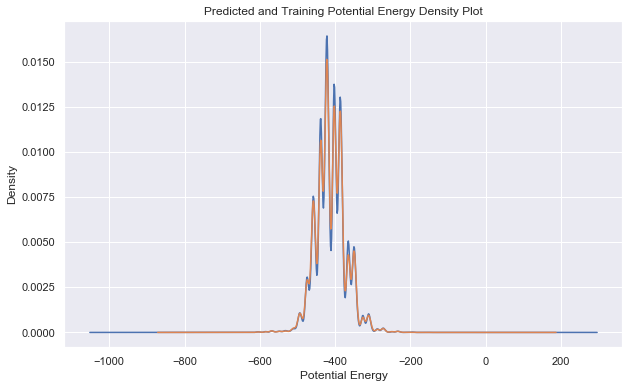

In [37]:
plt.figure(figsize=FIGSIZE)
molecule_train['potential_energy'].plot(kind='kde')
molecule_test['potential_energy'].plot(kind='kde')
plt.title("Predicted and Training Potential Energy Density Plot")
plt.xlabel("Potential Energy")
plt.show()

## Arrange updated potencial energy data frame

In [38]:
potential_energy_upd = potential_energy_upd.sort_values(id_feature)
potential_energy_upd.reset_index(drop=True, inplace=True)

In [39]:
potential_energy_upd.head()

,molecule_name,potential_energy
0,dsgdb9nsd_000001,-40.523680
1,dsgdb9nsd_000002,-56.560250
2,dsgdb9nsd_000003,-76.426080
3,dsgdb9nsd_000004,-77.359333
4,dsgdb9nsd_000005,-93.428490


## Save pickled data
This file contains training and predicted testing potential energy and it can be useful to add this feature in the `scalar_coupling_constant` competition 

In [22]:
if SAVE_PICKLE:
    output_file_path = "{}.pkl".format(OUTPUT_FILE)
    print("Saving pickled file {}...".format(output_file_path))
    potential_energy_upd.to_pickle(output_file_path)
    

Saving pickled file potential_energy_upd.pkl...


If you want to read this file use the command:    
    `potential_energy_upd = pd.read_pickle("potential_energy_upd.pkl")`